<a href="https://colab.research.google.com/github/birddropping/IND5003-Group-Project/blob/main/IND5003_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
#from functools import reduce

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [3]:
data_demo = pd.read_csv('data/demographic.csv')
data_diet = pd.read_csv('data/diet.csv')
data_exam = pd.read_csv('data/examination.csv')
data_labs = pd.read_csv('data/labs.csv')
data_meds = pd.read_csv('data/medications.csv', encoding = "ISO-8859-1") # Had to use this encoding standard to read file
data_qns = pd.read_csv('data/questionnaire.csv')
data_dict = pd.read_excel('NHANES 2014 Dictionary.xlsx')

data_vari = pd.read_excel('Variables.xlsx', squeeze = True)

In [4]:
glu_data = pd.read_sas('data/GLU_H.XPT') # Fasting glucose was not part of the original dataset. Added from NHANES website
vitd_data = pd.read_sas('data/VID_H.XPT')
data_labs = pd.merge(data_labs, glu_data[['SEQN','LBDGLUSI']], how='outer', on=['SEQN'], validate = '1:1')
data_labs = pd.merge(data_labs, vitd_data[['SEQN','LBXVIDMS']], how='outer', on=['SEQN'], validate = '1:1')


In [7]:
#remove duplicates from data_meds as each line covers 1 medication
data_meds_m = data_meds.drop_duplicates(subset = ['SEQN', 'RXDCOUNT'], keep = 'first')

#create a data frame with the illnesses and drugs plus 1 last column whether SEQN is diabetic or not
data_med_2=data_demo.loc[:,['SEQN']]
imax=len(data_demo['SEQN'])
druglist=data_meds['RXDDRUG']
illnesslist=data_meds['RXDRSD1']
med_SEQN=data_meds['SEQN']
SEQN=data_demo['SEQN']

for i in range(0,imax):
    string=''
    lis1=druglist.loc[data_meds['SEQN']==SEQN[i]]
    string=lis1.str.cat(sep=',').upper()
    data_med_2.loc[i,['druglist']]=string
    if string.find('INSULIN') >= 0:
        data_med_2.loc[i,['TAKE INSULIN']]='YES'
    else:
        data_med_2.loc[i,['TAKE INSULIN']]='NO'
    
    lis2=illnesslist.loc[data_meds['SEQN']==SEQN[i]].drop_duplicates(keep='first')
    
    string=lis2.str.cat(sep=',').upper()
    data_med_2.loc[i,['illness']]=string
    #check whether diabetetic
    if string.find('TYPE 1 DIAB') >= 0:
        data_med_2.loc[i,['DBT']]='TYPE 1'
    elif string.find('TYPE 2 DIAB') >= 0:
        data_med_2.loc[i,['DBT']]='TYPE 2'    
    elif string.find('PREVENT DIAB') >= 0:
        data_med_2.loc[i,['DBT']]='HIGH RISK'
    else:
        data_med_2.loc[i,['DBT']]='OTHERS'



Combine the 6 datasets together as 1 with SEQN as the lead. From there, we can trim out the variables that is not needed for our application of diabetes and mental health.

In [9]:
# Create massive dataset
dataset = pd.merge(data_demo, data_diet, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_exam, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_labs, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_meds_m, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_qns, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_med_2, how = 'outer', on = ['SEQN'], validate = "1:1")

#find out 
dataset.loc[(dataset['LBXGH']<=5.6),'Diabetic']='NO'
dataset['LBXGH'].fillna(value=0)
dataset.loc[((dataset['LBXGH']>5.6) & (dataset['LBXGH']<=6.4)),'Diabetic']='PREDIABETES'
dataset.loc[(dataset['LBXGH']>6.4),'Diabetic']='YES'


#depression score as a sum of the qns asked abt depression
tmp=dataset[['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']]

colMax=len(tmp.columns)
rowMax=len(tmp['DPQ010'])

for j in range(0,colMax):
    for i in range(0,rowMax):
        if (tmp.iloc[i,j]>6):
            tmp.iloc[i,j]=np.nan

tmp['Depression score']=tmp.sum(axis=1)

dataset[['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100','Depression score']]=tmp

#consumer behavior
tmp=dataset[['CBD070','CBD110','CBD120','CBD130']]

colMax=len(tmp.columns)
rowMax=len(tmp['CBD070'])

for j in range(0,colMax):
    for i in range(0,rowMax):
        if (tmp.iloc[i,j]>=70000) or (tmp.iloc[i,j]==0):
            tmp.iloc[i,j]=np.nan

tmp['Diet spending']=tmp.sum(axis=1)
dataset[['CBD070','CBD110','CBD120','CBD130','Diet spending']]=tmp

dataset

C:\Users\TanDe\AppData\Local\Temp/ipykernel_18092/2899563866.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Depression score']=tmp.sum(axis=1)
C:\Users\TanDe\AppData\Local\Temp/ipykernel_18092/2899563866.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Diet spending']=tmp.sum(axis=1)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,BPXML1,BPXSY1,BPXDI1,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,BMXBMI,BMDBMIC,BMXLEG,BMILEG,BMXARML,...,PAQ759G,PAQ759H,PAQ759I,PAQ759J,PAQ759K,PAQ759L,PAQ759M,PAQ759N,PAQ759O,PAQ759P,PAQ759Q,PAQ759R,PAQ759S,PAQ759T,PAQ759U,PAQ759V,PAQ762,PAQ764,PAQ766,PAQ679,PAQ750,PAQ770,PAQ772A,PAQ772B,PAQ772C,PAAQUEX,PUQ100,PUQ110,RHQ010,RHQ020,RHQ031,RHD043,RHQ060,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U,RXQ510,RXQ515,RXQ520,RXQ525G,RXQ525Q,RXQ525U,RXD530,SLD010H,SLQ050,SLQ060,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD055,SMD057,SMQ078,SMD641,SMD650,SMD093,SMDUPCA,SMD100BR,SMD100FL,SMD100MN,SMD100LN,SMD100TR,SMD100NI,SMD100CO,SMQ621,SMD630,SMQ661,SMQ665A,SMQ665B,SMQ665C,SMQ665D,SMQ670,SMQ848,SMQ852Q,SMQ852U,SMAQUEX2,SMD460,SMD470,SMD480,SMQ856,SMQ858,SMQ860,SMQ862,SMQ866,SMQ868,SMQ870,SMQ872,SMQ874,SMQ876,SMQ878,SMQ880,SMAQUEX.x,SMQ681,SMQ690A,SMQ710,SMQ720,SMQ725,SMQ690B,SMQ740,SMQ690C,SMQ770,SMQ690G,SMQ845,SMQ690H,SMQ849,SMQ851,SMQ690D,SMQ800,SMQ690E,SMQ817,SMQ690I,SMQ857,SMQ690J,SMQ861,SMQ863,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX.y,SXD021,SXQ800,SXQ803,SXQ806,SXQ809,SXQ700,SXQ703,SXQ706,SXQ709,SXD031,SXD171,SXD510,SXQ824,SXQ827,SXD633,SXQ636,SXQ639,SXD642,SXQ410,SXQ550,SXQ836,SXQ841,SXQ853,SXD621,SXQ624,SXQ627,SXD630,SXQ645,SXQ648,SXQ610,SXQ251,SXQ590,SXQ600,SXD101,SXD450,SXQ724,SXQ727,SXQ130,SXQ490,SXQ741,SXQ753,SXQ260,SXQ265,SXQ267,SXQ270,SXQ272,SXQ280,SXQ292,SXQ294,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ060,WHQ070,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,WHD080I,WHD080J,WHD080K,WHD080M,WHD080N,WHD080O,WHD080P,WHD080Q,WHD080R,WHD080S,WHD080T,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520,druglist,TAKE INSULIN,illness,DBT,Diabetic,Depression score,Diet spending
0,73557,8,2,1,69,NaN,4,4,

In [ ]:
#create a column that counts NA 


In [80]:
# Create list of variables of interest
col_list = data_vari.tolist()

# Creating dataframe with variables of interest
final_data = dataset[col_list]

# Subsetting based on glycohaemoglobin levels
final_data = final_data.dropna(subset=['LBXGH']) 

inputs=dataset[['SEQN','Diabetic','Diet spending','Depression score']]
final_data=final_data.merge(inputs)

final_data

,SEQN,RXDCOUNT,RXDDAYS,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,DR1TALCO,DR1.320Z,LBDGLTSI,LBDGLUSI,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DIQ160,DIQ170,DIQ172,DIQ175A,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,PAQ605,PAQ610,PAD615,PAQ620,PAQ625,PAD630,PAQ635,PAQ640,PAD645,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,PAQ710,PAQ715,WHQ030,WHQ070,DBQ700,HSD010,WHD110,WHD120,BMXWT,Diabetic,Diet spending,Depression score
0,73557,2.0,NaN,1,69,4,26.7,122.0,72.0,114.0,76.0,102.0,74.0,0.0,960.0,NaN,NaN,1.68,4.32,28.9,13.9,NaN,NaN,NaN,NaN,8.0,8.0,0.0,4.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,8.0,3.0,NaN,2.0,2.0,270.0,200.0,78.3,YES,435.0,2.0
1,73558,4.0,243.0,1,54,3,28.6,156.0,62.0,160.0,80.0,156.0,42.0,119.0,360.0,NaN,NaN,1.29,4.40,61.9,9.1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2.0,2.0,1.0,7.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,10.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,540.0,4.0,8.0,3.0,2.0,3.0,4.0,240.0,250.0,89.5,YES,830.0,2.0
2,73559,5.0,365.0,1,72,3,28.9,140.0,90.0,140.0,76.0,146.0,80.0,0.0,1254.0,NaN,10.713,1.55,3.26,126.0,8.9,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,2.0,2.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,1.0,7.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,180.0,300.0,4.0,0.0,3.0,2.0,3.0,3.0,180.0,190.0,88.9,YES,190.0,0.0
3,73561,4.0,152.0,2,73,3,19.7,136.0,86.0,134.0,88.0,142.0,86.0,0.0,240.0,NaN,5.940,2.20,5.20,108.0,4.9,2.0,2.0,2.0,NaN,0.0,NaN,4.0,1.0,2.0,2.0,15.0,15.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,1.0,2.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,480.0,1.0,1.0,2.0,2.0,2.0,5.0,150.0,135.0,52.0,NO,240.0,10.0
4,73562,7.0,365.0,1,56,1,41.7,160.0,84.0,158.0,82.0,154.0,80.0,0.0,1014.0,NaN,NaN,0.98,5.84,44.3,5.5,2.0,2.0,1.0,NaN,14.0,14.0,0.0,0.0,2.0,2.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,1.0,5.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,360.0,5.0,8.0,1.0,1.0,5.0,5.0,225.0,195.0,105.0,NO,210.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6638,83721,1.0,91.0,1,52,3,25.6,108.0,70.0,112.0,72.0,108.0,76.0,0.0,0.0,NaN,NaN,1.42,3.57,109.0,5.4,2.0,2.0,2.0,NaN,15.0,0.0,0.0,0.0,2.0,2.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,4.0,120.0,1.0,3.0,120.0,240.0,2.0,8.0,3.0,2.0,1.0,2.0,172.0,163.0,79.5,NO,1150.0,0.0
6639,83723,NaN,NaN,1,61,1,33.1,NaN,NaN,138.0,60.0,142.0,68.0,0.0,3000.0,NaN,8.826,1.27,4.81,59.4,7.4,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2.0,2.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,30.0,360.0,3.0,8.0,1.0,NaN,3.0,4.0,240.0,200.0,99.5,YES,770.0,0.0
6640,83724,5.0,10950.0,1,80,3,24.9,164.0,70.0,168.0,66.0,168.0,66.0,0.0,690.0,NaN,NaN,1.32,4.06,89.9,5.5,2.0,2.0,2.0,NaN,1.0,1.0,0.0,30.0,2.0,2.0,8.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,7.0,60.0,360.0,2.0,8.0,3.0,2.0,2.0,2.0,173.0,140.0,77.1,NO,668.0,1.0
6641,83727,NaN,NaN,1,26,2,24.5,110.0,68.0,116.0,74.0,112.0,76.0,14.0,867.0,5.995,5.995,1.42,4.91,81.5,5.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,1.0,3.0,2.0,4.0,3.0,NaN,NaN,71.8,NO,1500.0,0.0


As shown in previous cell, all datasets have been combined and only features related to diabetes and mental health have been filtered out to create the dataset from which analysis will be done.

In [20]:
SES = ['INDHHIN2', 'INDFMIN2', 'FSD151', 'FSQ165']
SES_data = final_data[SES]
SES_data

,INDHHIN2,INDFMIN2,FSD151,FSQ165
0,4.0,4.0,2.0,1.0
1,7.0,7.0,2.0,1.0
2,10.0,10.0,2.0,2.0
4,15.0,15.0,2.0,2.0
5,9.0,9.0,2.0,2.0
...,...,...,...,...
10164,15.0,15.0,2.0,2.0
10166,10.0,10.0,2.0,1.0
10167,8.0,8.0,2.0,2.0
10170,77.0,77.0,2.0,2.0


In [21]:
SES_data.describe()

,INDHHIN2,INDFMIN2,FSD151,FSQ165
count,6560.000000,6565.000000,6572.000000,6572.000000
mean,11.033994,10.614166,1.894553,1.683810
std,13.886365,13.706318,0.321673,0.514433
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,2.000000,1.000000
50%,8.000000,7.000000,2.000000,2.000000
75%,14.000000,14.000000,2.000000,2.000000
max,99.000000,99.000000,7.000000,9.000000


Coded results for household/family income

|Value|Salary Range|
|-----|------------|
|1|0 to 4999|
|2|5000 to 9999|
|3|10000 to 14999|
|4|15000 to 19999|
|5|20000 to 24999|
|6|25000 to 34999|
|7|35000 to 44999|
|8|45000 to 54999|
|9|55000 to 64999|
|10|65000 to 74999|
|12|20000 and over|
|13|under 20000|
|14|75000 to 99999|
|15|100000 and over|

We will have to replace NaN values, 77 and 99 which are refuse to answer and do not know respectively.

In [22]:
#Replace 77.0 and 99.0 with NaN value first, before replacing all NaN values with the mean of the remainder.
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].fillna(round(SES_data.loc[:,'INDHHIN2'].mean()))

SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].fillna(round(SES_data.loc[:,'INDFMIN2'].mean()))

C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [23]:
#Too many catergories that are not in order to make sense when plotting a histogram
#Convert data values to only have 4 catergories

#Cat 1 is under 20000
replace_values_cat1 = {2:1, 3:1, 4:1, 13:1}
#Cat 2 is 20000 to 74999
replace_values_cat2 = {5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 12:2}
#Cat 3 is 75000 to 99999
replace_values_cat3 = {14:3}
#Cat 4 is 100000 and above
replace_values_cat4 = {15:4}

#Replace the values in 'INDHHIN2' to create 4 catergories
SES_data['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat4, inplace=True)

#Replace the values in 'INDFMIN2' to create 4 catergories
SES_data['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat4, inplace=True)

final_data['INDFMIN2'] = SES_data['INDFMIN2']
final_data['INDHHIN2'] = SES_data['INDHHIN2']

C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [24]:
check=[11]
#check that the value 11 is not in the column as it is not represented in the value coding table above for feature
# INDHHIN2 and INDFMIN2 which are household income and family income respectively
SES_data['INDHHIN2'].isin(check).sum()

0

In [25]:
#Should be removed before main integration for project submission

SES_data['INDFMIN2'].isin(check).sum()

0

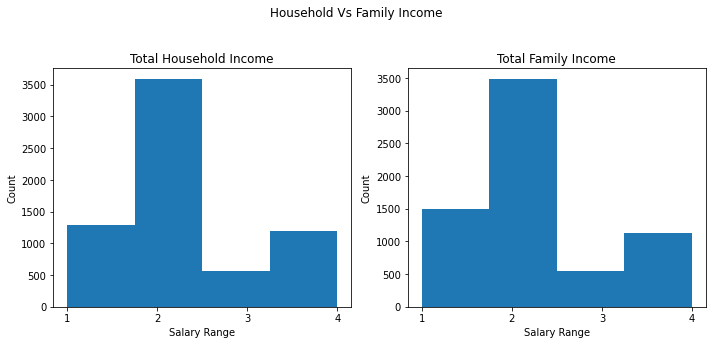

In [26]:
#Plot the income indicators into histograms according to the new catergories that we arranged them in

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data['INDHHIN2'], bins=4)
ax1.set_ylabel("Count")
ax1.set_xlabel("Salary Range")
ax1.set_title("Total Household Income")
ax1.set_xticks([1,2,3,4]) 
ax1.set_xticklabels([1,2,3,4])

ax2.hist(SES_data['INDFMIN2'], bins=4)
ax2.set_ylabel("Count")
ax2.set_xlabel("Salary Range")
ax2.set_title("Total Family Income")
ax2.set_xticks([1,2,3,4]) 
ax2.set_xticklabels([1,2,3,4])

fig.suptitle("Household Vs Family Income")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [27]:
SES_data['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data['FSD151'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data['FSD151'].fillna(round(SES_data['FSD151'].mean()), inplace=True)

SES_data['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data['FSQ165'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data['FSQ165'].fillna(round(SES_data['FSQ165'].mean()), inplace=True)

final_data['FSD151'] = SES_data['FSD151']
final_data['FSQ165'] = SES_data['FSQ165']

C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


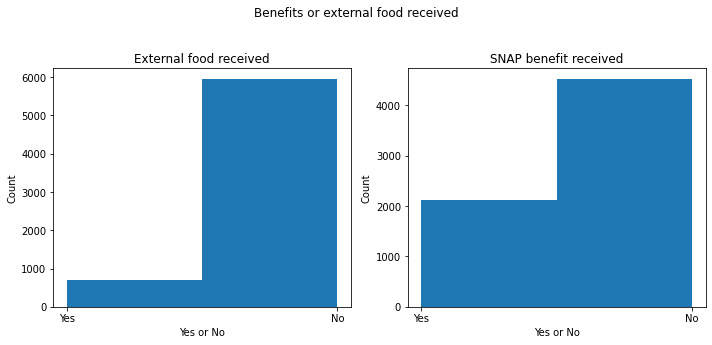

In [28]:
# Features showing benefit

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data['FSD151'], bins=2)
ax1.set_ylabel("Count")
ax1.set_xlabel("Yes or No")
ax1.set_title("External food received")
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Yes','No'])

ax2.hist(SES_data['FSQ165'], bins=2)
ax2.set_ylabel("Count")
ax2.set_xlabel("Yes or No")
ax2.set_title("SNAP benefit received")
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Yes','No'])

fig.suptitle("Benefits or external food received")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [29]:
# subsetting dataset based on available HbA1c data
mh = ['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']
mental_health = final_data[mh]
final_data.loc[:,'DPQ_score'] = mental_health.drop('SEQN', axis=1).sum(axis=1) # summing up scores

# mental health summary statistic - 4 categories - 0 for normal, 1 for mild, 2 for moderate, 3 for severe
final_data.loc[:,'mental_health_stat'] = pd.cut(final_data['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)

final_data = final_data.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

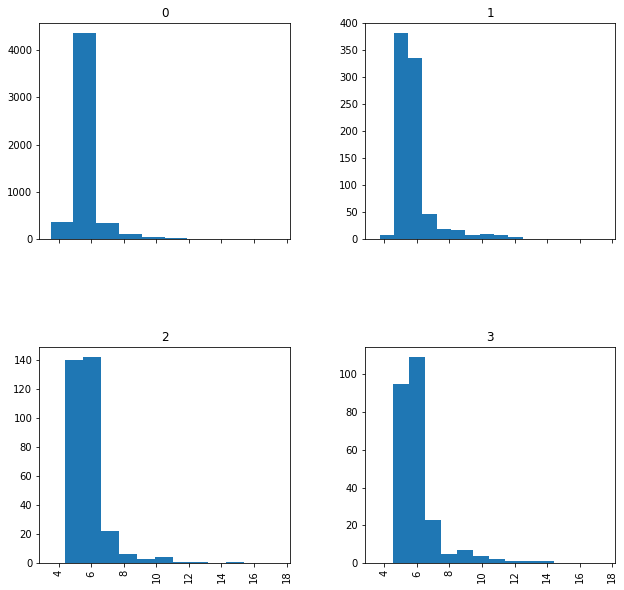

In [30]:
final_data.hist(by='mental_health_stat', column = 'LBXGH',figsize=(10,10), sharex = True)

In [31]:
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
final_data.loc[:,'WHQ030'] = final_data['WHQ030'].fillna(3).replace(9,3) 
# selecting 'no' for individuals who did not respond to this qn, replacing 'unsure' responses with nil response
final_data.loc[:,'WHQ070'] = final_data['WHQ070'].fillna(2).replace(9,2) 
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
final_data.loc[:,'DBQ700'] = final_data['DBQ700'].fillna(3).replace(9,3)
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value\
final_data.loc[:,'HSD010'] = final_data['HSD010'].fillna(3).replace(9,3)

# Subsetting and creating scores for individual self-perception questions
sp = ['SEQN','WHQ030','WHQ070','DBQ700', 'HSD010']
self_perception = final_data[sp]
self_perception.loc[:,'WHQ030_score'] = self_perception['WHQ030'].replace([1,2],0).replace(3,2)
self_perception.loc[:,'WHQ070_score'] = self_perception['WHQ070'].replace(1,0)
self_perception.loc[:,'DBQ700_score'] = self_perception['DBQ700']-1
self_perception.loc[:,'HSD010_score'] = self_perception['HSD010']-1

# Creating summary score for self perception
final_data.loc[:,'self_perception_stat'] = self_perception[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
final_data.loc[:,'self_perception_stat'] = pd.cut(final_data.loc[:,'DPQ_score'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)

final_data = final_data.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)

C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

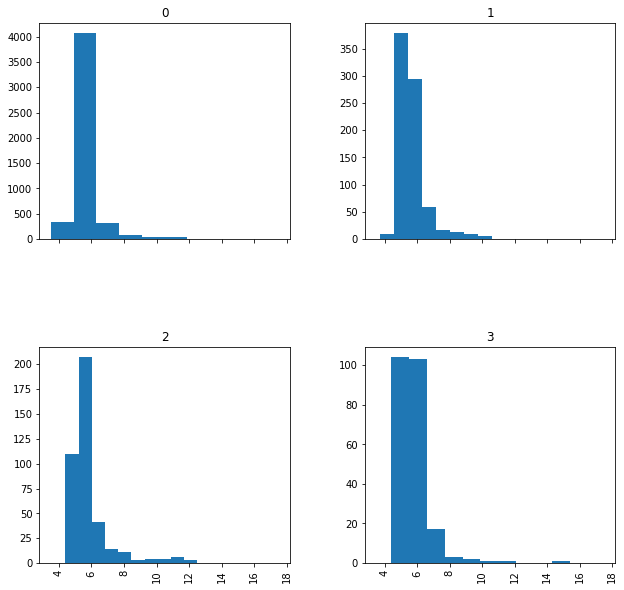

In [32]:
final_data.hist(by='self_perception_stat', column = 'LBXGH', figsize= (10,10), sharex = True)

In [33]:
wc = ['SEQN','WHD110','WHD120', 'BMXWT']
weight_change = final_data[wc]

weight_change.loc[:,'WHD110'] = weight_change.loc[:,'WHD110'].replace(7777,np.nan).replace(9999,np.nan) / 2.20462

weight_change.loc[:,'weight_change_10_years'] = weight_change.loc[:,'BMXWT'] - weight_change.loc[:,'WHD110']
final_data.loc[:,'wc_10yr_score'] = pd.cut(weight_change['weight_change_10_years'], [-120,-20,-5,5,20, 120], labels = [0, 1, 2, 3, 4])
final_data['wc_10yr_score'].replace(np.NaN,2,inplace=True)
final_data = final_data.drop(['WHD110','WHD120','BMXWT'], axis=1)

C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

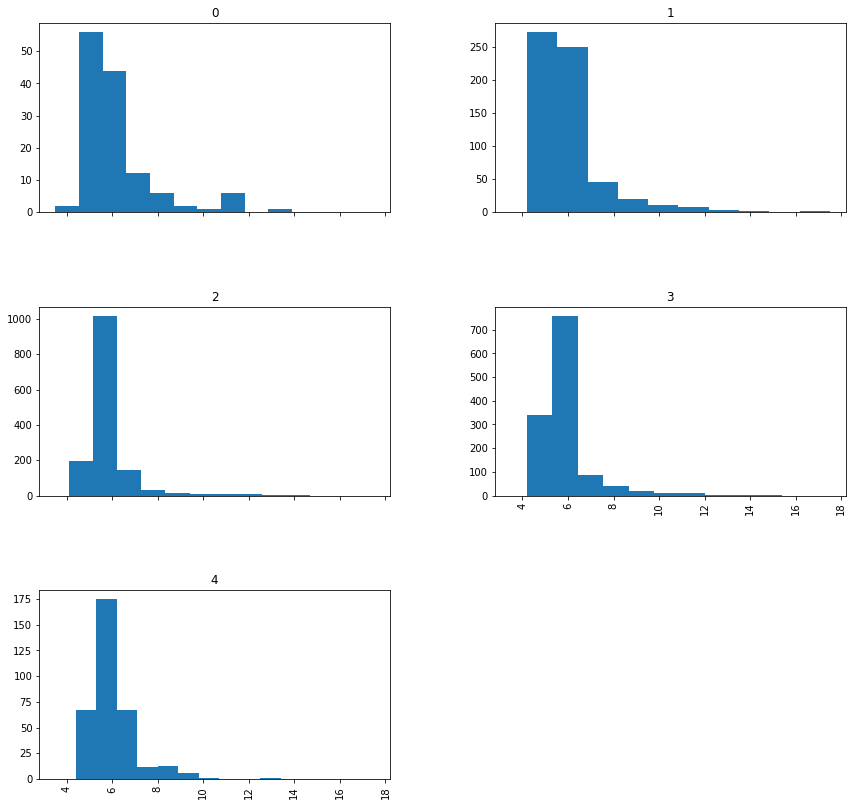

In [34]:
final_data.hist(by='wc_10yr_score', column='LBXGH', figsize = (14,14), sharex = True)

In [35]:
# Cleaning number of medications
final_data['RXDCOUNT'] = final_data['RXDCOUNT'].replace(np.NaN, 0)

# Defining average blood pressure
final_data.loc[:,'AVGSYBP'] = round(final_data[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
final_data.loc[:,'AVGDIBP'] = round(final_data[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))

# Dropping base features relating to 1,2,3 measurements of Systolic and Diastolic BP
final_data = final_data.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)

# Cleaning data for DBD895. >21 responses normalized to 21. unsure participants normalized to mean number of meals
final_data['DBD895'] = final_data['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(final_data['DBD895'])))
final_data['DBD900'] = final_data['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(final_data['DBD900'])))
# Calculating proportion of fast food compared to all other meals consumed outside
avg_meals = final_data['DBD900'] / final_data['DBD895']
avg_meals = avg_meals.replace(np.inf, 0)
avg_meals = avg_meals.where(avg_meals < 1 ,1)
final_data['PROFFMEAL'] = avg_meals

final_data['DBD905'] = final_data['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(final_data['DBD905'])))   
final_data['DBD910'] = final_data['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(final_data['DBD910'])))   

final_data.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','wc_10yr_score'],axis=1, inplace=True)

In [36]:
#Create working database for activity
activity = ["LBXGH","PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk = final_data.loc[:,activity]

#drop "PAQ706" due to poor data
#code out target variable "DM"
#code activity levels
activity1 = ["LBXGH","PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk = final_data.loc[:,activity1]
activity_wk["DM"] = activity_wk["LBXGH"]>6.5
activity_wk["activity_lvl_high"] = np.where((activity_wk.PAQ650 == 1) | (activity_wk.PAQ605 == 1), 1, np.NaN)
activity_wk["activity_lvl_med"] = np.where((activity_wk["PAQ620"] == 1) | (activity_wk["PAQ665"] == 1), 2, np.NaN)
activity_wk["activity_lvl_low"] =  (activity_wk["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)


activity_wk["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk["activity_lvl_low"].replace(False, np.NaN, inplace=True)
#activity_wk[activity_wk["activity_lvl_high"]==0].replace(0,activity_wk["activity_lvl_med"], inplace=True )
#activity_wk["activity_lvl_high"].replace(0,activity_wk["activity_lvl_med"], inplace =True)
activity_wk["activity_lvl"] = activity_wk[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)

final_data['activity_lvl'] = activity_wk['activity_lvl']

final_data.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)

In [37]:
final_data.dropna(axis=0,how='any', inplace = True)

In [38]:
final_data

,SEQN,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ_score,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,73557,2.0,1,69,4,26.7,0.0,960.0,1.68,4.32,28.9,13.9,8.0,8.0,0.0,4.0,2.0,1.0,1.0,1.0,2.0,0,0,113.0,74.0,1.0,3.0
1,73558,4.0,1,54,3,28.6,119.0,360.0,1.29,4.40,61.9,9.1,0.0,4.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,0,0,157.0,61.0,0.0,2.0
2,73559,5.0,1,72,3,28.9,0.0,1254.0,1.55,3.26,126.0,8.9,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0,0,142.0,82.0,0.0,2.0
4,73561,4.0,2,73,3,19.7,0.0,240.0,2.20,5.20,108.0,4.9,0.0,4.0,4.0,1.0,2.0,2.0,4.0,4.0,10.0,2,3,137.0,87.0,0.0,2.0
7,73564,3.0,2,61,3,35.7,34.2,1134.0,1.50,4.34,102.0,5.5,5.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0,0,123.0,81.0,0.2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10164,83721,1.0,1,52,3,25.6,0.0,0.0,1.42,3.57,109.0,5.4,15.0,0.0,0.0,0.0,2.0,2.0,4.0,4.0,0.0,0,0,109.0,73.0,0.0,1.0
10166,83723,0.0,1,61,1,33.1,0.0,3000.0,1.27,4.81,59.4,7.4,1.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,0,0,140.0,64.0,0.0,2.0
10167,83724,5.0,1,80,3,24.9,0.0,690.0,1.32,4.06,89.9,5.5,1.0,1.0,0.0,30.0,2.0,2.0,2.0,2.0,1.0,0,0,167.0,67.0,1.0,2.0
10170,83727,0.0,1,26,2,24.5,14.0,867.0,1.42,4.91,81.5,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0,0,113.0,73.0,1.0,3.0


  
  
# DATA ANALYSIS
  
  

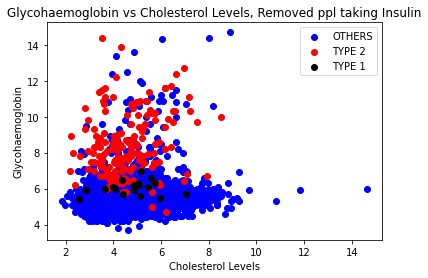

In [91]:
#merge datasets for Exploratory Data Analysis
X_merge=pd.concat([X_train,X_test],ignore_index=True)
Y_merge=pd.concat([y_train,y_test],ignore_index=True)
combine=X_merge
combine['Diabetic']=Y_merge
combine


#Silhouette score table for the unscaled dataset

#X = final_data.drop('LBXGH', axis=1)
#y = np.where(final_data['LBXGH'] >=6.5, 1, 0)

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
X1=X_merge
nb_cluster=[2,3,4,5,6,7,8,9,10]
avg_sil=[]
for n in nb_cluster:
    km=KMeans(n_clusters=n,random_state=10)
    Y1=km.fit_predict(X1)
    avg_sil.append(silhouette_score(X1,Y1))
    
plt.figure(0)
plt.title('Silhouette score vs Number of clusters')
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')
plt.plot(nb_cluster,avg_sil)

plt.show()
Sil_score=pd.DataFrame()
Sil_score['Number of Cluster']=nb_cluster
Sil_score['Silhouette Score']=avg_sil
Sil_score


#ward linkage of the unscaled dataset
from scipy.cluster.hierarchy import dendrogram, linkage

X2=linkage(X_merge,method='ward')
plt.figure(0)
plt.title('Dendrogram of Test Group')
Xd2=dendrogram(X2)

tmp=X_merge
for n in tmp.columns:
    tmp2=np.unique(tmp[n])
    tmp2.sort()
    tmp2 = tmp2[np.logical_not(np.isnan(tmp2))]
    #if number of unique values are more than 10, it is continuous variable
    #else it is categorical
    if len(tmp2) <= 15:
        print(n,' is categorical with values: ',tmp2)
    else:
        print(n,' is range with min: ',min(tmp2),' and max: ',max(tmp2))
        
        
        
        
#compare our 2 groups
#X = final_data.drop('LBXGH', axis=1)
#y = np.where(final_data['LBXGH'] >=6.5, 1, 0)

lgd=[
    'Non-Diabetic group',
    'Diabetic group',
]
tmp=X_merge
c=0
for n in tmp.columns:
    plt.figure(c)
    X_nondiabetic=tmp.loc[Y_merge==0,n]
    X_diabetic=tmp.loc[Y_merge==1,n]
    plt.hist(X_nondiabetic,color='blue',bins=20)#non-diabetic grp
    plt.hist(X_diabetic,color='red',bins=20)#diabetic grp
    title='Histogram of ' + str(n)
    plt.title(title)
    
    tmp2=np.unique(tmp[n])
    tmp2.sort()
    if len(tmp2)>5:
        plt.axvline(np.mean(X_nondiabetic),color='blue')#non-diabetic grp
        plt.axvline(np.mean(X_diabetic),color='red')#diabetic grp
        plt.ylabel('Count')
        plt.xlabel(n)
        plt.xticks(rotation=90)
        plt.legend(lgd)
        plt.show()

        print('The mean of ',n,' for non-diabetic group is:',np.mean(X_nondiabetic))
        print('The mean of ',n,' for diabetic group is:',np.mean(X_diabetic))
    else:
        plt.ylabel('Count')
        plt.xlabel(n)
        plt.xticks(rotation=90)
        plt.legend(lgd)
        plt.show()
    print('---------------------------------------------------------------------------------------')
    c=c+1    
    

C:\Users\TanDe\AppData\Local\Temp/ipykernel_18092/187170591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['feature']=inputs.iloc[:,i]


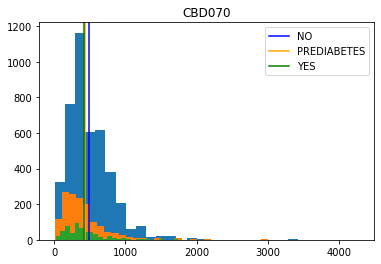

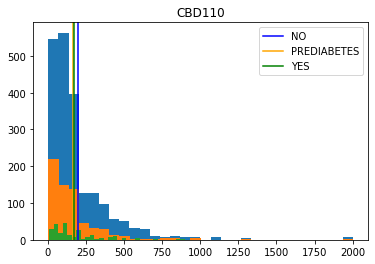

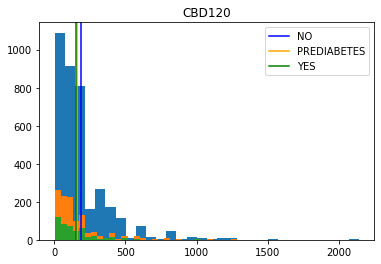

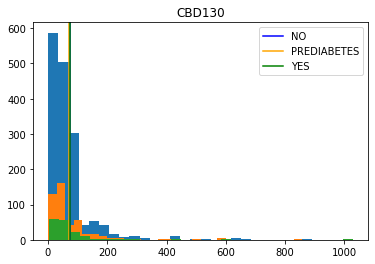

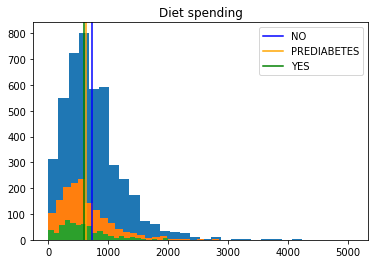

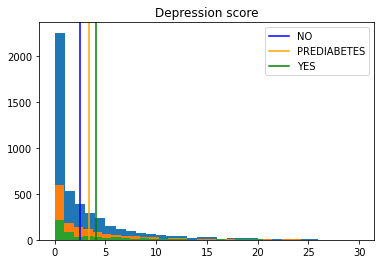

people with no diabetes spend more at supermarket/grocery store than people with prediabetes and diabetes, not yet hypothesis tested
people with diabetes then to be more depressed than people without, not yet hypothesis tested


In [90]:
#histogram
inputs=dataset[['CBD070','CBD110','CBD120','CBD130','Diet spending','Depression score']]
tmp=dataset[['SEQN','Diabetic']]

colMax=len(inputs.columns)
list1=inputs.columns.values
lgd=[
    'NO',
    'PREDIABETES',
    'YES',
]

for i in range(0,colMax):
    tmp2=tmp
    tmp2['feature']=inputs.iloc[:,i]
    string=list1[i]
    plt.figure(i)
    X1=tmp2['feature'].loc[tmp2['Diabetic']=='YES']
    X2=tmp2['feature'].loc[tmp2['Diabetic']=='PREDIABETES']
    X3=tmp2['feature'].loc[tmp2['Diabetic']=='NO']
    plt.hist(X3,bins=30)
    plt.axvline(X3.mean(),c='blue')
    plt.hist(X2,bins=30)
    plt.axvline(X2.mean(),c='orange')
    plt.hist(X1,bins=30)
    plt.axvline(X1.mean(),c='green')
    plt.title(list1[i])
    plt.legend(lgd)
    
plt.show()
print('people with no diabetes spend more at supermarket/grocery store than people with prediabetes and diabetes, not yet hypothesis tested')
print('people with diabetes then to be more depressed than people without, not yet hypothesis tested')

C:\Users\TanDe\AppData\Local\Temp/ipykernel_18092/4241799699.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[feature1]=input1.iloc[:,i]
C:\Users\TanDe\AppData\Local\Temp/ipykernel_18092/4241799699.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


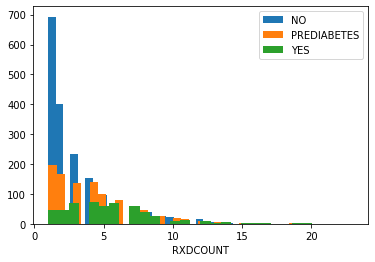

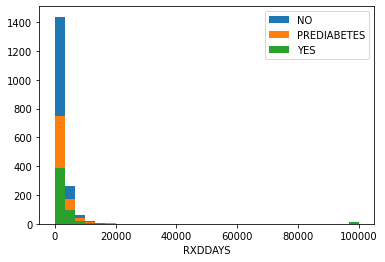

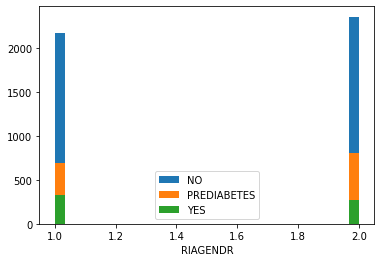

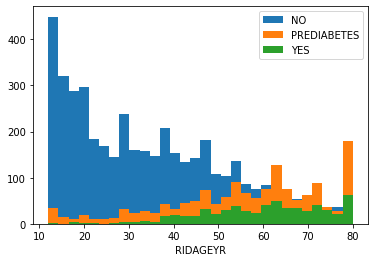

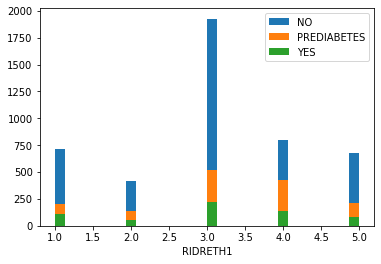

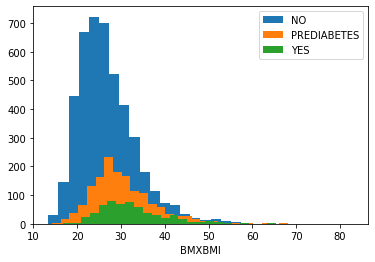

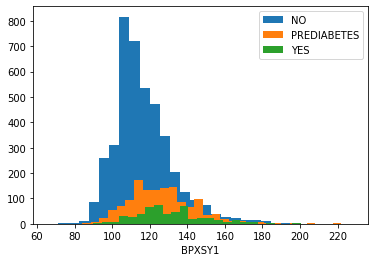

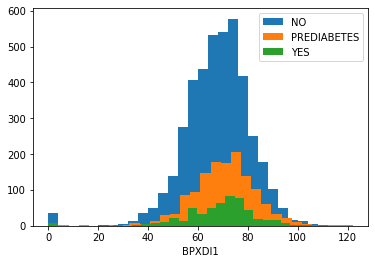

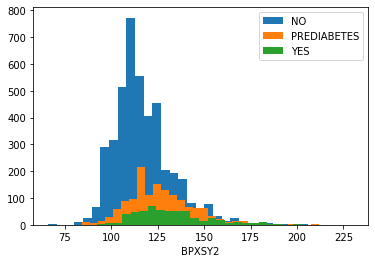

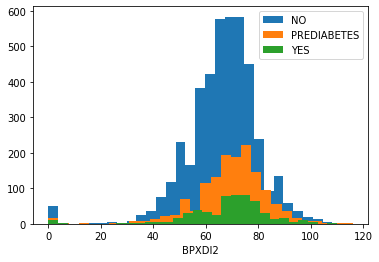

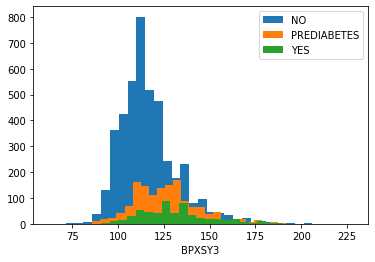

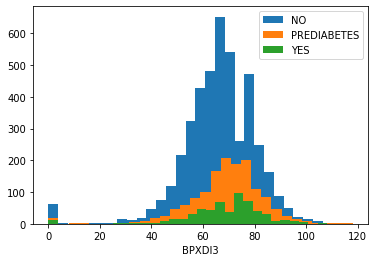

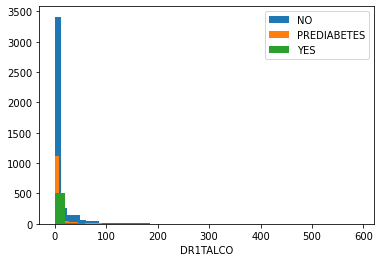

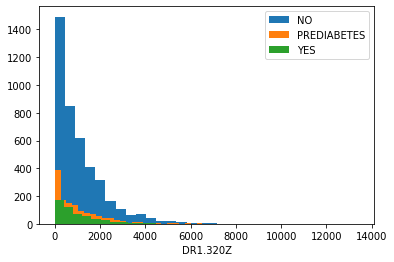

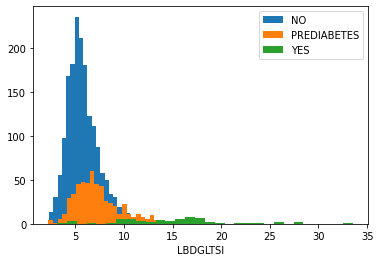

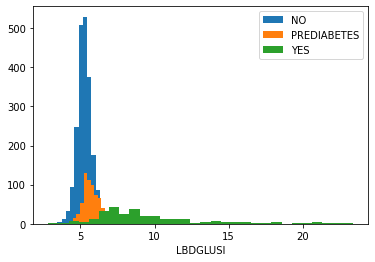

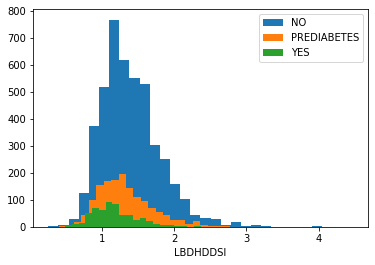

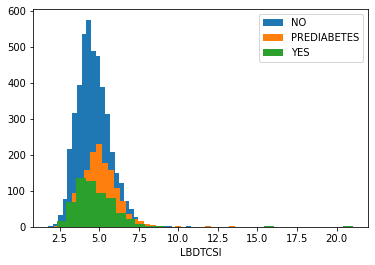

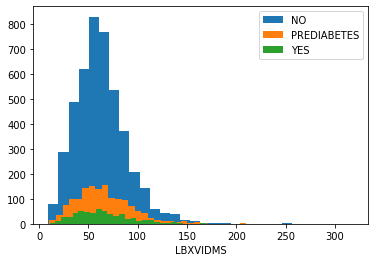

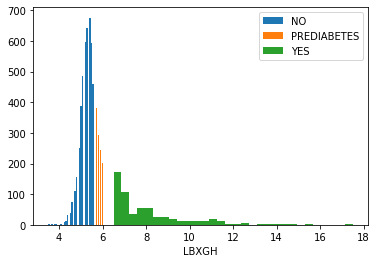

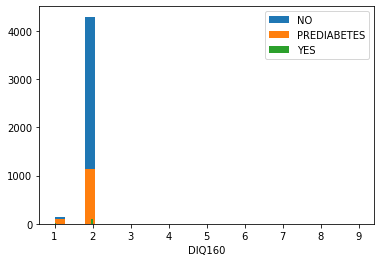

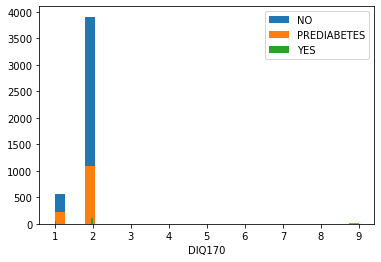

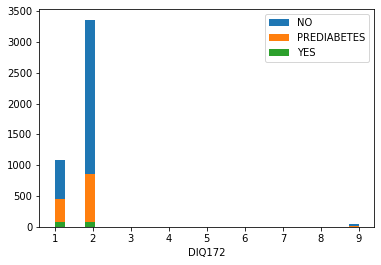

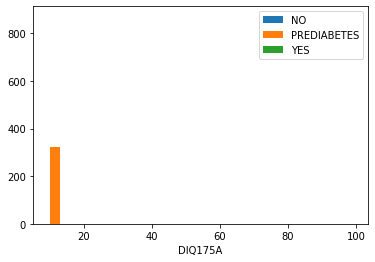

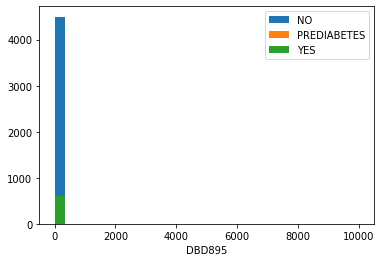

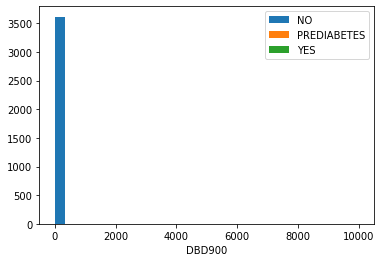

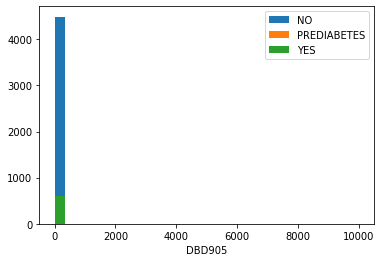

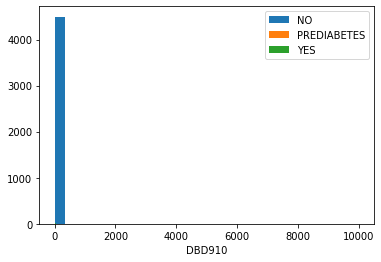

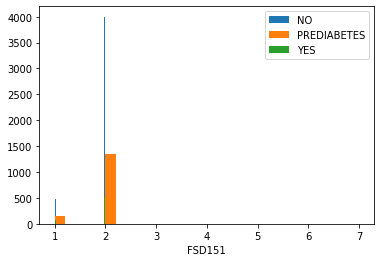

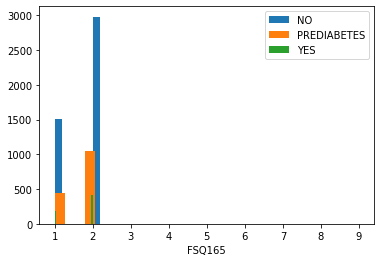

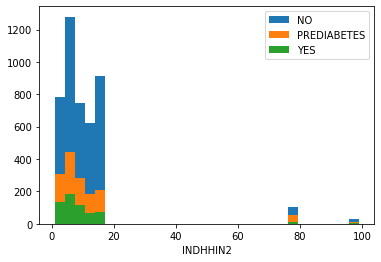

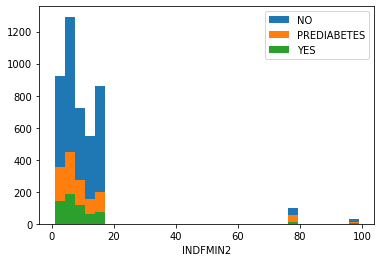

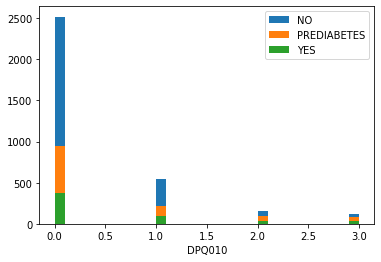

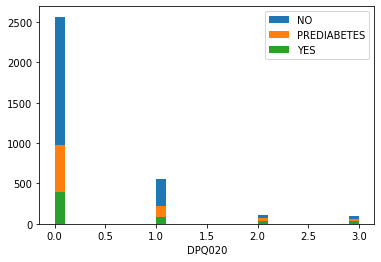

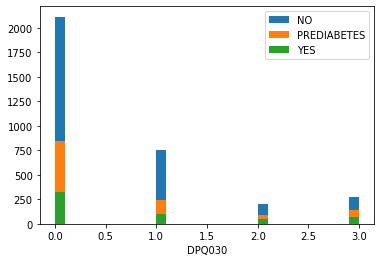

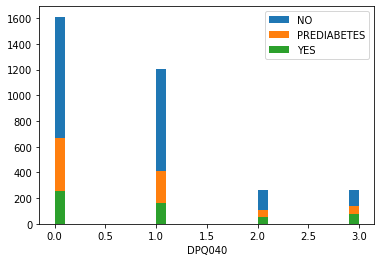

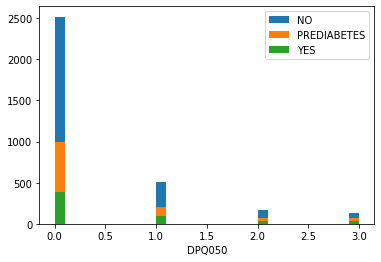

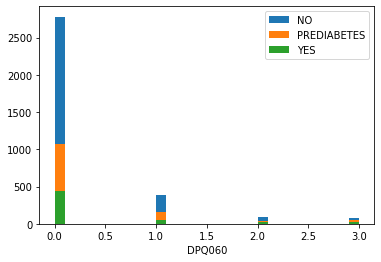

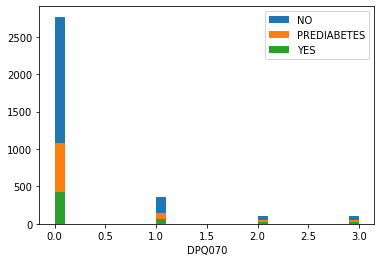

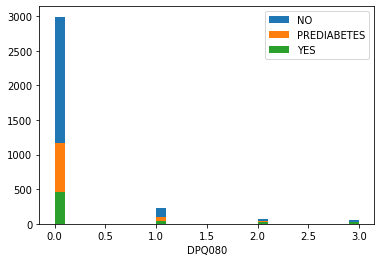

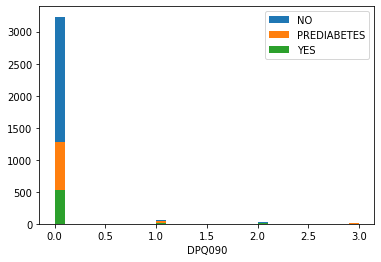

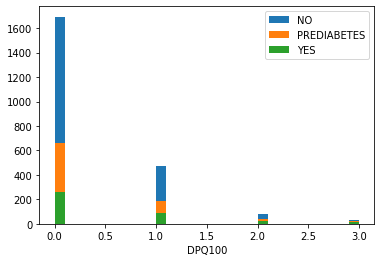

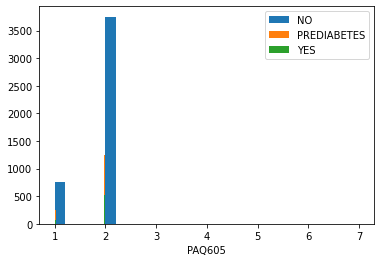

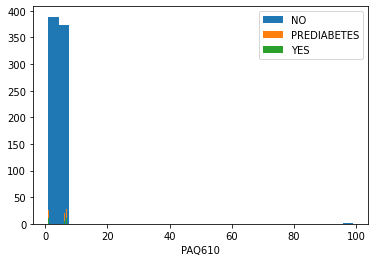

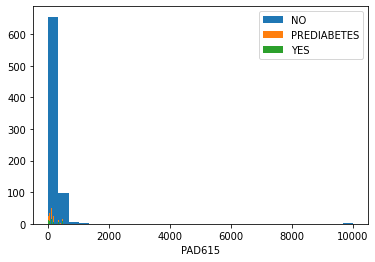

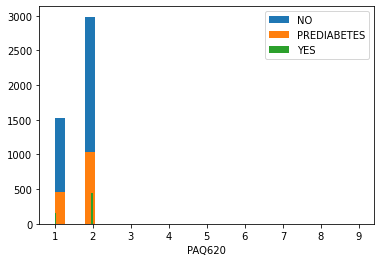

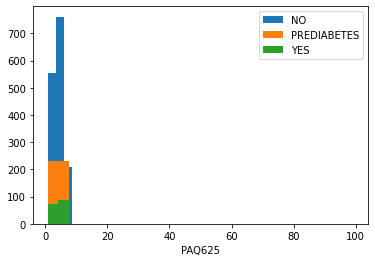

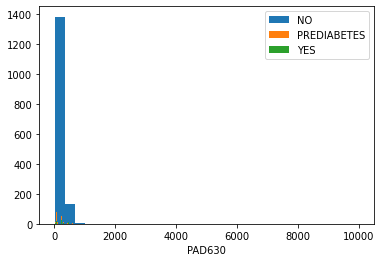

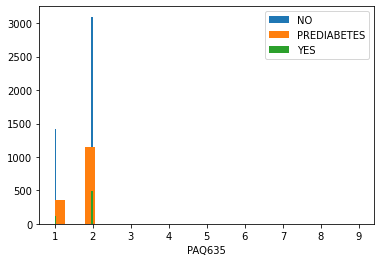

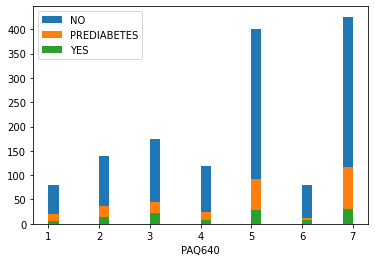

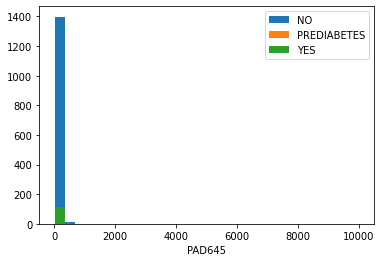

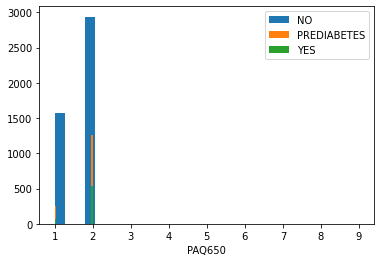

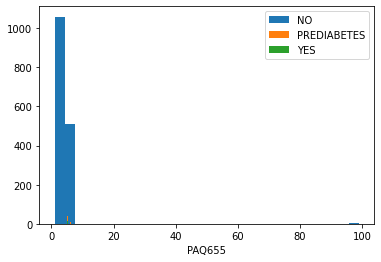

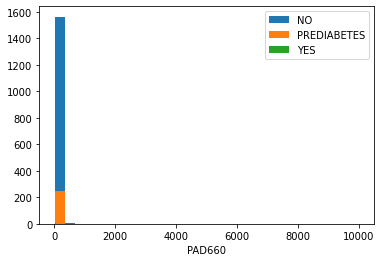

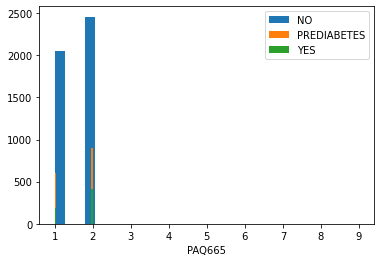

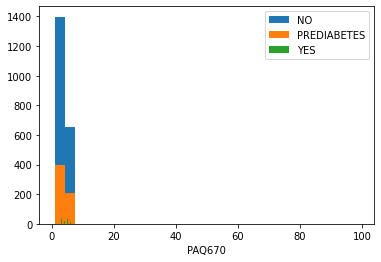

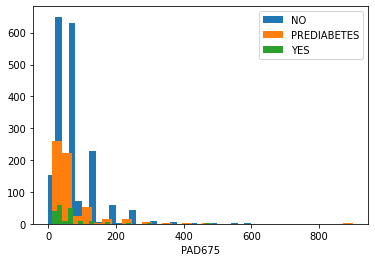

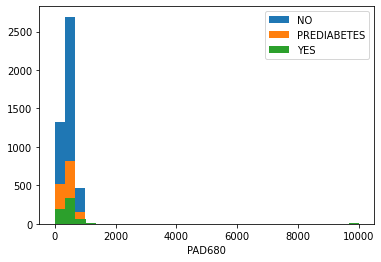

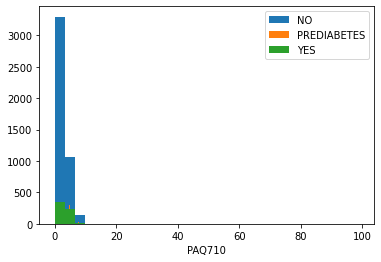

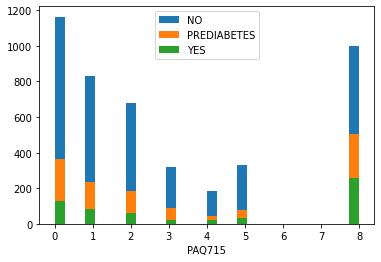

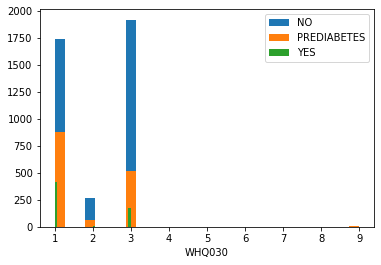

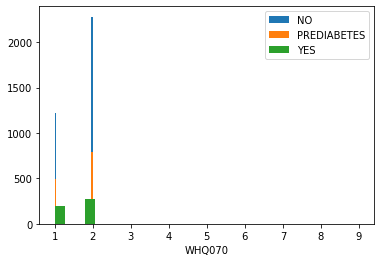

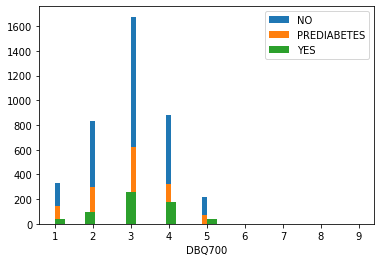

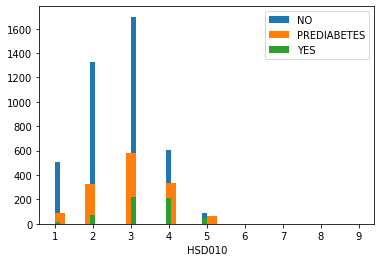

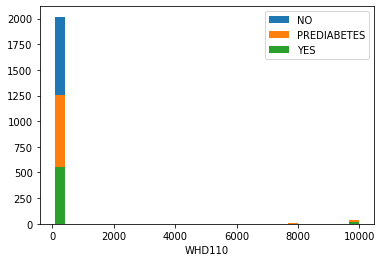

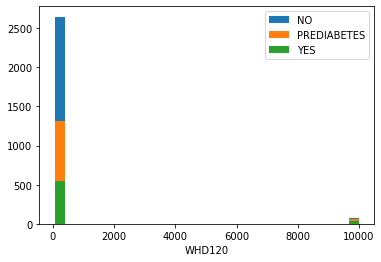

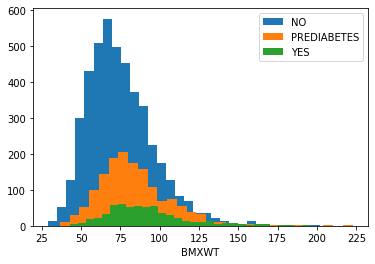

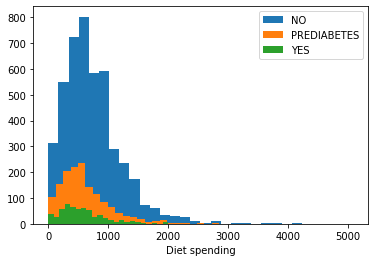

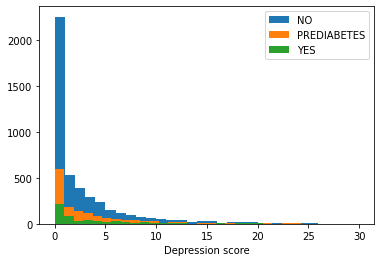

In [89]:
#count number of NA for each row
#distrubutions of continuous variables and categorical variables


tmp=final_data[['SEQN','Diabetic']]
input1=final_data.drop(columns=['SEQN','Diabetic'])

colMax=len(input1.columns)
list1=input1.columns.values

lgd=[
    'NO',
    'PREDIABETES',
    'YES',
]

for i in range(0,colMax):
    tmp2=tmp
    feature1=list1[i]
    tmp2[feature1]=input1.iloc[:,i]
    string=list1[i]
    plt.figure(i)
    X1=tmp2[feature1].loc[tmp2['Diabetic']=='YES']
    X2=tmp2[feature1].loc[tmp2['Diabetic']=='PREDIABETES']
    X3=tmp2[feature1].loc[tmp2['Diabetic']=='NO']
    plt.hist(X3,bins=30)
    #plt.axvline(X3.mean(),c='blue')
    plt.hist(X2,bins=30)
    #plt.axvline(X2.mean(),c='orange')
    plt.hist(X1,bins=30)
    #plt.axvline(X1.mean(),c='green')
    plt.xlabel(feature1)
    plt.legend(lgd)
    
plt.show()